In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import datetime
import csv
import yaml
import configparser
import copy
import math 
import random
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
# mpl.use('Agg')
%matplotlib inline
# %matplotlib notebook
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5

# 1. Data Loading

In [4]:
ROOT_PATH = '../'
try: 
    os.chdir(ROOT_PATH)
    sys.path.insert(0, ROOT_PATH)
    print("Current working directory: {}".format(os.getcwd()))
except Exception:
    print("Directory: {} is not valid".format(ROOT_PATH))
    sys.exit(1)

Current working directory: /home/geshi/ABCDFusion


In [5]:
# load and parse config 
config_file = './configs.yaml'
with open(config_file, 'r') as infile:
    try:
        configs = yaml.safe_load(infile)
    except yaml.YAMLError as exc:
        sys.exit(exc)

In [6]:
auxiliary = configs['Auxiliary']
hyper_params = configs['HyperParams']

DATA_PATH = auxiliary['DATA_PATH']
DTI_DATA = auxiliary['DTI_DATA'] 
OUTCOME = auxiliary['OUTCOME']

test_size = hyper_params['valid_size']
num_splits = hyper_params['num_splits']
seed = hyper_params['seed']

In [7]:
df_data = pd.read_csv(os.path.join(DATA_PATH, DTI_DATA))
df_labels = pd.read_csv(os.path.join(DATA_PATH, OUTCOME))

In [8]:
dfs = pd.read_excel('data/DataforGe_v2.xlsx', sheet_name=None)

In [9]:
dfs_dti = dfs['DTIConnectData']

In [10]:
shared_subjects = set(df_labels['src_subject_id']).intersection(\
    set(dfs_dti['src_subject_id']))

In [11]:
print(len(shared_subjects))

3946


In [12]:
dfs_dti = dfs_dti[dfs_dti['src_subject_id'].isin(shared_subjects)]

In [13]:
print(len(dfs_dti))

3946


In [14]:
dfs_dti.to_csv('data/DTIConnectData.csv', index=False)

In [15]:
set(df_labels['src_subject_id']) - set(df_data['src_subject_id'])

set()

In [16]:
df_data.head()

,src_subject_id,FA_cingulatecingulum_R_site,FA_CinguluteCingulum_L_site,FA_corpuscallosum_site,FA_Corticospinal_L_site,FA_Corticospinal_R_site,FA_forecepsmajor_site,FA_forecepsminor_site,FA_Fornix_L_site,FA_Fornix_R_site,...,FA_striatal_IFC_L_site,FA_striatal_IFC_R_site,FA_superiorcorticalstriate_Frontal_L_site,FA_superiorcorticalstriate_Frontal_R_site,FA_superiorcorticalstriate_Parietal_L_site,FA_superiorcorticalstriate_Parietal_R_site,FA_ThalamicRadiations_R_site,FA_thalamicradiations_L_site,FA_uncinate_L_site,FA_uncinate_R_site
0,NDAR_INV2LXFHK41,0.513469,0.517282,0.605080,0.645676,0.629430,0.660285,0.567513,0.393273,0.391117,...,0.460385,0.412272,0.473630,0.465818,0.490398,0.496094,0.364269,0.377859,0.497738,0.483780
1,NDAR_INVA1PNCBDH,0.332010,0.403138,0.538148,0.527821,0.557823,0.621612,0.517549,0.352306,0.345156,...,0.357968,0.344473,0.381727,0.418348,0.437987,0.479137,0.358184,0.371618,0.399834,0.382088
2,NDAR_INV1VM14D0X,0.421600,0.452436,0.532047,0.537978,0.546210,0.583973,0.452367,0.361542,0.373303,...,0.373593,0.341535,0.389115,0.420812,0.441207,0.459445,0.365005,0.362151,0.410082,0.374020
3,NDAR_INVDPP9W7AV,0.419015,0.453392,0.519705,0.579116,0.597663,0.535006,0.467251,0.374419,0.360455,...,0.357944,0.349888,0.419882,0.468370,0.445834,0.462607,0.370926,0.382564,0.395354,0.383492
4,NDAR_INVP7YTV29E,0.413164,0.469708,0.543775,0.539368,0.551975,0.605714,0.463675,0.359970,0.371690,...,0.361040,0.347350,0.403998,0.411654,0.421241,0.452689,0.341516,0.360926,0.398593,0.367081


In [17]:
df_labels.head()

,src_subject_id,becomeCHR_3yr,diffusivity_all fibers_site,diffusivity_L_ hemisphere fibers_site,diffusivity_L_ hemisphere fibers without corpus callosum_site,diffusivity_R_hemisphere fibers without corpus callosum_site,diffusivity_R_hemisphere fibers_site,CortThk_L_mean_agesexsite,CortThk_R_mean_agesexsite,CortThkcortical Destrieux ROI mean_agesexsite
0,NDAR_INV00CY2MDM,0,0.516813,0.516055,0.516193,0.515086,0.516470,2.692631,2.718348,2.703962
1,NDAR_INV00HEV6HB,0,0.504674,0.503342,0.503085,0.507389,0.504825,2.557290,2.649288,2.664290
2,NDAR_INV014RTM1V,0,0.499351,0.493832,0.500397,0.511758,0.501866,2.630886,2.585186,2.647286
3,NDAR_INV01AJ15N9,0,0.499413,0.497758,0.503652,0.508636,0.501104,2.798921,2.781255,2.795671
4,NDAR_INV01NAYMZH,0,0.484313,0.482630,0.486149,0.488122,0.484919,2.598179,2.620402,2.604037


In [18]:
X = df_data.iloc[:,3:].values
y = df_labels.iloc[:,1].values
classes = [0, 1]

In [19]:
X.shape

(3946, 29)

# 2. Machine Learning

## 2.1 Define Classifiers

In [20]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix, auc
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [21]:
import umap

In [22]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

In [23]:
rng = np.random.RandomState(seed)

In [24]:
classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025, random_state=seed),
    SVC(gamma=2, C=1, random_state=seed),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=seed),
    DecisionTreeClassifier(max_depth=5, random_state=seed),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=seed
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=seed),
    AdaBoostClassifier(random_state=seed),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

## 2.2 Visualize Data Distribution and Do Simple Test

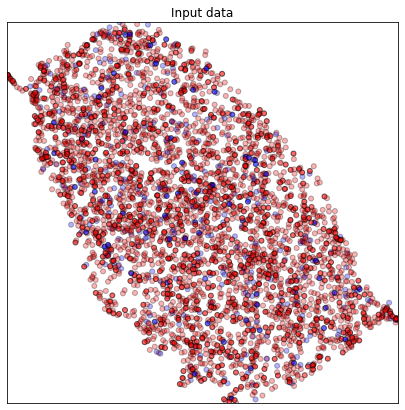

Train classifier Nearest Neighbors
| classes | precision | recall | fscore | support |
|    0    |  0.916  |  0.997  |  0.955  |   723   |
|    1    |  0.333  |  0.015  |  0.029  |    67   |
micro f1 score is 0.9139
confusion matrix is 
 [[721   2]
 [ 66   1]]
Train classifier Linear SVM


| classes | precision | recall | fscore | support |
|    0    |  0.915  |  1.000  |  0.956  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9152
confusion matrix is 
 [[723   0]
 [ 67   0]]


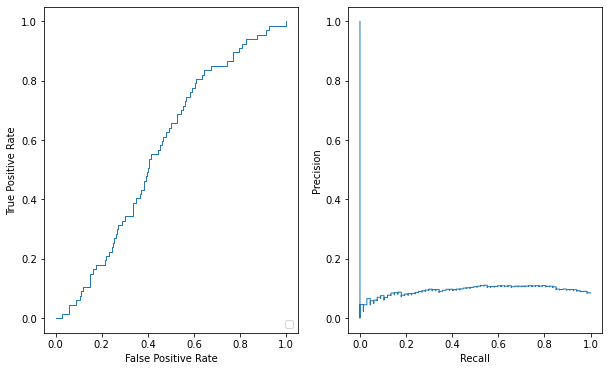

Train classifier RBF SVM


| classes | precision | recall | fscore | support |
|    0    |  0.915  |  1.000  |  0.956  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9152
confusion matrix is 
 [[723   0]
 [ 67   0]]


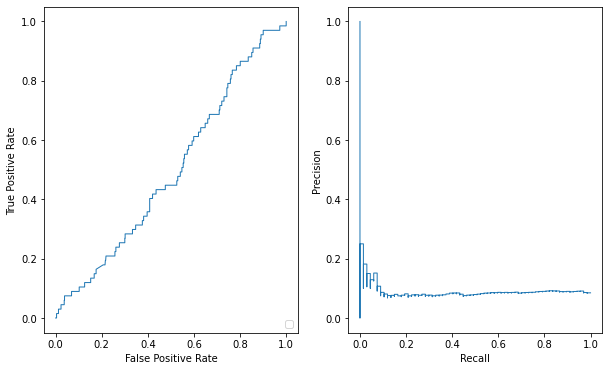

Train classifier Gaussian Process
| classes | precision | recall | fscore | support |
|    0    |  0.915  |  1.000  |  0.956  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9152
confusion matrix is 
 [[723   0]
 [ 67   0]]
Train classifier Decision Tree
| classes | precision | recall | fscore | support |
|    0    |  0.915  |  0.993  |  0.952  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9089
confusion matrix is 
 [[718   5]
 [ 67   0]]
Train classifier Random Forest
| classes | precision | recall | fscore | support |
|    0    |  0.915  |  1.000  |  0.956  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9152
confusion matrix is 
 [[723   0]
 [ 67   0]]
Train classifier Neural Net
| classes | precision | recall | fscore | support |
|    0    |  0.915  |  1.000  |  0.956  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9152
confusion matrix 

| classes | precision | recall | fscore | support |
|    0    |  0.915  |  0.994  |  0.953  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9101
confusion matrix is 
 [[719   4]
 [ 67   0]]


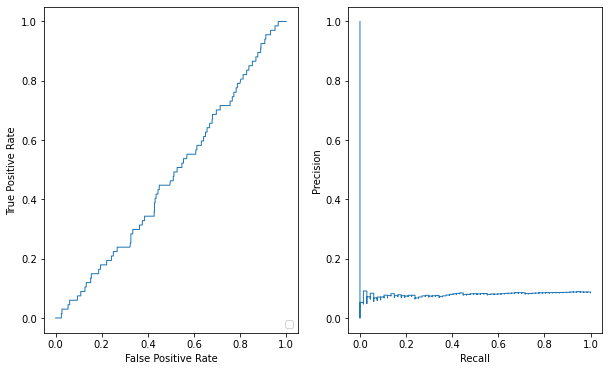

Train classifier Naive Bayes
| classes | precision | recall | fscore | support |
|    0    |  0.915  |  0.997  |  0.954  |   723   |
|    1    |  0.000  |  0.000  |  0.000  |    67   |
micro f1 score is 0.9127
confusion matrix is 
 [[721   2]
 [ 67   0]]
Train classifier QDA
| classes | precision | recall | fscore | support |
|    0    |  0.915  |  0.986  |  0.949  |   723   |
|    1    |  0.091  |  0.015  |  0.026  |    67   |
micro f1 score is 0.9038
confusion matrix is 
 [[713  10]
 [ 66   1]]


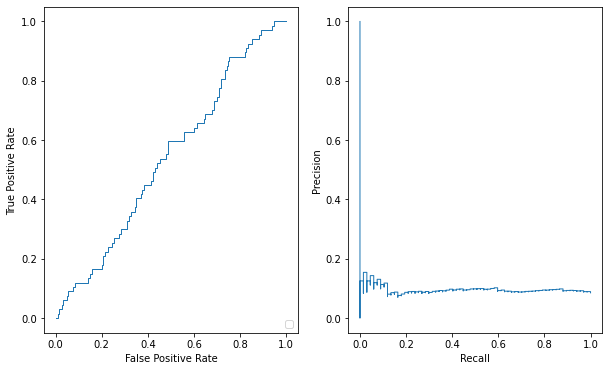

In [25]:
reducer = umap.UMAP()
X_embedding = reducer.fit_transform(X)

X_train, X_test, y_train, y_test, Xm_train, Xm_test = train_test_split(
    X, y, X_embedding, test_size=test_size, random_state=seed
)

x_min, x_max = X_embedding[:, 0].min(), X_embedding[:, 0].max()
y_min, y_max = X_embedding[:, 1].min(), X_embedding[:, 1].max()

reducer = umap.UMAP()
# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Input data")    
# Plot the training points
ax.scatter(Xm_train[:, 0], Xm_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.3, edgecolors="k")
# Plot the testing points
ax.scatter(
    Xm_test[:, 0], Xm_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
plt.show()

# iterate over classifiers
for name, clf in zip(names, classifiers):
    
    print('Train classifier {}'.format(name))
    clf = make_pipeline(StandardScaler(), clf)
    # clf = make_pipeline(clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calcute statistics
    precision, recall, fscore, support = score(y_test, y_pred)    

    print('| {:^6} | {:^6} | {:^6} | {:^6} | {:^6} |'.format('classes', 'precision', 'recall', 'fscore', 'support'))
    for cla, pre, rec, f1, sup in zip(classes, precision, recall, fscore, support):
        print('|  {:^6} |  {:^.3f}  |  {:^.3f}  |  {:^.3f}  |  {:^6} |'.format(cla, pre, rec, f1, sup))
        
    test_fscore = f1_score(y_test, y_pred, average='micro')
    print('micro f1 score is {:.4f}'.format(test_fscore))
    test_cfm = confusion_matrix(y_test, y_pred)
    print('confusion matrix is \n', test_cfm)
    
    # Display curves
    try:
        y_score = clf.decision_function(X_test)
        ## ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        ## precision recall curve
        prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
        pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
        ## visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
        roc_display.plot(ax=ax1)
        pr_display.plot(ax=ax2)
        plt.show()
    except:
        continue

## 2.2 Cross Validation

In [26]:
cv = StratifiedKFold(n_splits=num_splits)
# pick one from classifiers
classifier = classifiers[9]
clf = make_pipeline(StandardScaler(), classifier)
# classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
# pick one from classifiers

         fpr      tpr     1-fpr       ass  thresholds
57  0.345354  0.42029  0.654646  0.537468    -2.45558
         fpr       tpr     1-fpr       ass  thresholds
41  0.273232  0.323529  0.726768  0.525149   -2.206632
          fpr       tpr     1-fpr       ass  thresholds
113  0.841886  0.882353  0.158114  0.520233   -4.817352
          fpr  tpr     1-fpr       ass  thresholds
123  0.919556  1.0  0.080444  0.540222    -5.53964
         fpr       tpr     1-fpr       ass  thresholds
53  0.384189  0.441176  0.615811  0.528494   -3.042714


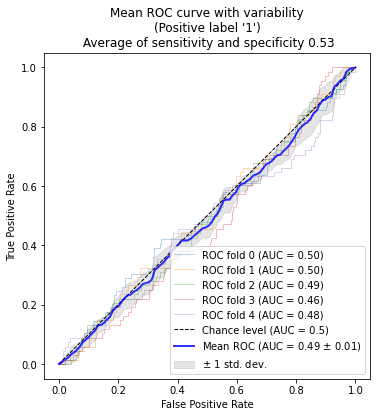

In [27]:
tprs = []
aucs = []
yis = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    clf.fit(X[train], y[train])
    
    y_score = clf.decision_function(X[test])
    fpr, tpr, thresholds =roc_curve(y[test], y_score, pos_label=clf.classes_[1])
    roc_auc = auc(fpr, tpr)
    
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'ass' : pd.Series((tpr + (1-fpr))/2, index = i), 'thresholds' : pd.Series(thresholds, index = i)})
    yi = roc.iloc[(-roc['ass']).argsort()[:1]]
    print(yi)
    yis.append(yi['ass'].iloc[0])
    
    viz = RocCurveDisplay.from_estimator(
        clf,
        X[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == num_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_yi = np.mean(yis)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label '{classes[1]}')\n Average of sensitivity and specificity {mean_yi:.2f}",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()